In [2]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)
verbose = True
run_mode = 'debug'

# GRB pop module imports
from GRB_population import GRBPopulation
import physics as ph
import stats as st
import io_grb_pop as io
from io_grb_pop import root_dir
import miscellaneous as msc
import plotting_functions as pf
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import observational_constraints as obs

# General imports
import yaml
import logging
import corner
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

# specific imports
from scipy.stats import ks_2samp
from scipy.stats import norm
from scipy.stats import mstats
from itertools import product

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.style.use('paper')
colors = ['#225ea8', '#41b6c4', '#d94801', '#fd8d3c']

Sample size :1313
Sample size :82


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


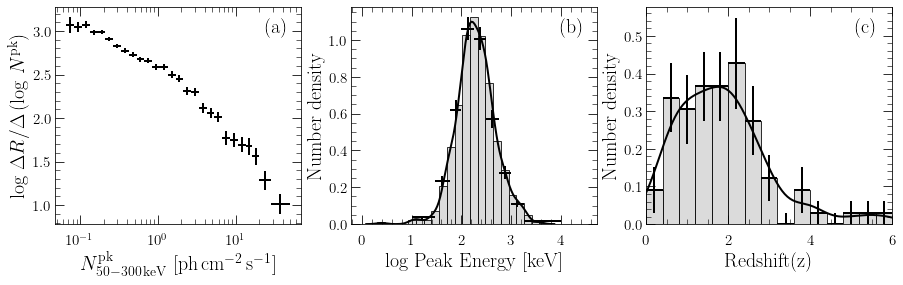

In [2]:
plt.style.use('presentation')
# This is the plot that shows all three observational constraints in one figure
bins_Ep = np.linspace(0,4.5, 30)

fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)

# Intensity Constraint
bins_Stern, obs_lin, err_lin = obs.create_Stern_hist()
x, x_errp, x_errm = pf.xerr_from_bins(bins_Stern, log=True)
axes[0].errorbar(x, obs_lin, xerr=[x_errm, x_errp], yerr=err_lin,  color='k', fmt='none')
axes[0].set_xscale('log')
axes[0].set_xlabel(r'$N^{\rm pk}_{50-300\,\rm keV}~\rm{[ph\,cm^{-2}\,s^{-1}]}$')
axes[0].set_ylabel(r'log $\Delta R/\Delta \,(\log\,N^{\rm pk})$')
# axes[0].set_ylabel(r'$\Delta R/\Delta \,(\log\,N^{\rm pk})\,\rm{[yr^{-1} }$ in $4\pi$]')
axes[0].text(0.85, 0.88, '(a)', **{'size':20}, transform=axes[0].transAxes)

# Spectral Constraint
pf.plot_EpGBM(ax=axes[1], density=True, color='k', fmt='none', bins_log=True)
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'}],
                  log=True, verbose=True, kde=True,
                  bins=bins_Ep,
                  ax=axes[1], density=True, label='Spectral Constraint', alpha=0.8,
                  color='lightgray', errors='coerce')
axes[1].get_legend().remove()
axes[1].set_xlabel(r'log Peak Energy $\rm{[keV]}$')
axes[1].set_ylabel(r'Number density')
# axes[1].yaxis.set_label_position('right')
axes[1].text(0.85, 0.88, '(b)', **{'size':20}, transform=axes[1].transAxes)

# Redshift constraint
bins_eBAT6, obs_lin, err_lin = obs.create_eBAT6_hist(density=True)
x, x_errp, x_errm = pf.xerr_from_bins(bins_eBAT6)
df = pf.plot_obs_property('../catalogs/BAT6_cat/eBAT6_cat.txt', header=3,
                  key='redshift',
                  log=False, verbose=True, kde=True,
                  bins=bins_eBAT6,
                  ax=axes[2], density=True, label=None, alpha=0.8,
                  color='lightgray', errors='coerce')
# sns.kdeplot(df, kernel='gau', ax=axes[2], color='C0', bw='silverman')
axes[2].errorbar(x, obs_lin, xerr=[x_errm, x_errp], yerr=err_lin,  color='k', fmt='none')
axes[2].get_legend().remove()
axes[2].set_ylim(0)
axes[2].set_xlim(0,6)
axes[2].set_xlabel('Redshift(z)')
axes[2].set_ylabel(r'Number density')
# axes[2].yaxis.set_label_position('right')
# axes[2].yaxis.tick_right()
axes[2].text(0.85, 0.88, '(c)', **{'size':20}, transform=axes[2].transAxes)

plt.show()
# fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/obs_constraints.pdf',
#            bbox_inches='tight')

Freshly read N_data: 3906
After filtering, N_data (excluding NaNs): 3906
Freshly read N_data: 2489
After filtering, N_data (excluding NaNs): 1920
First GRB detected on 2008-07-14 00:00:00
Last GRB detected on 2019-01-29 00:00:00
Duration: 10.572 years
Freshly read N_data: 2489
After filtering, N_data (excluding NaNs): 1920
30.554555904374087 4.9798994974874375
Fraction of time searching * fraction of the sky observed = 0.4710278867722148 yr
Effective duration of GBM search * GBM search angle = 62.579262707688144 sr yr


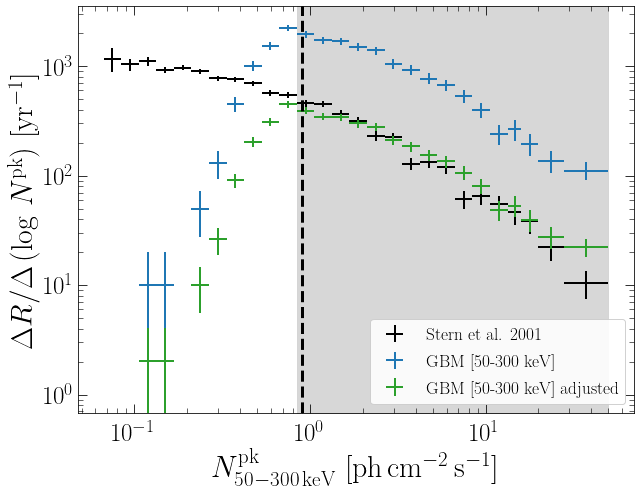

In [3]:
# This plot is to show the selection on the GBM sample in order to create the spectral constraint

plt.style.use('paper')
def plot_logNlogP(fname, key, func=None, func_args={}, bins=None, sep=None, hdr=None, density=False,
                  cols=None, ax=None, eff=False, errors='raise', log=False, factor=None,
                  Stern_first_bin_corr=False, cat_duration=False, **kwargs):
    # Read data
    df_obs = pd.read_csv(fname, sep=sep, header=hdr, names=cols, low_memory=False)
    # Strip the colum names to remove whitespaces
    df_obs.rename(columns=lambda x:x.strip(), inplace=True)
    print("Freshly read N_data: {}".format(len(df_obs.index)))
    if cat_duration:
        calc_cat_duration(fname, verbose=True)
    # Apply function to the data
    if func is None:
        df_prop = pd.to_numeric(df_obs[key], errors=errors)
    # If func is a list, iterate through the list and apply each function
    elif isinstance(func, list):
        if not isinstance(func_args, list):
            raise ValueError
        df_prop = df_obs.copy()
        for i, func_i in enumerate(func):
            df_prop = func_i(df_prop, **func_args[i])
        df_prop = pd.to_numeric(df_prop[key], errors=errors)
    else:
        df_prop = func(df_obs.copy(), **func_args)
        df_prop = pd.to_numeric(df_prop[key], errors=errors)

    print("After filtering, N_data (excluding NaNs): {}".format(df_prop.count()))
    if log:
        df_prop = np.log10(df_prop)

    if bins is None:
        bins = Stern_bins()
    x, x_errp, x_errm = pf.xerr_from_bins(bins, log=True)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))
    hist, bins = np.histogram(df_prop, bins=bins)
    hist_err = np.sqrt(hist)
    
    if eff:
        hist =  hist / obs.efficiency_correction_Stern(x)
        hist_err =  hist_err / obs.efficiency_correction_Stern(x)
    if density:
        N_tot = np.sum(hist)
    else:
        N_tot = 1
    delta_bins = np.log10(bins[1:]/bins[:-1])
    hist = hist/(N_tot*delta_bins)
    hist_err = hist_err/(N_tot*delta_bins)

    if factor is not None:
        hist = hist/factor
        hist_err = hist_err/factor
    if Stern_first_bin_corr:
        hist[0], hist_err[0], _ = msc.log_to_lin(3.069180, 9.691000e-02)
    ax.errorbar(x, hist, xerr=[x_errm, x_errp], yerr=hist_err,
                fmt='none', **kwargs)

    return hist, hist_err

def calc_cat_duration(fname, verbose=False):
    from datetime import datetime
    data = pd.read_csv(fname, sep='|', header=2, low_memory=False)
    data.rename(columns=lambda x:x.strip(), inplace=True)
    first_date = datetime.strptime(data['name'].min().strip('GRB')[:-3], '%y%m%d')
    last_date = datetime.strptime(data['name'].max().strip('GRB')[:-3], '%y%m%d')
    delta_t = (last_date - first_date).days/364.25
    if verbose:
        print('First GRB detected on {}'.format(first_date))
        print('Last GRB detected on {}'.format(last_date))
        print('Duration: {:.3f} years'.format(delta_t))
    return delta_t


T_live_BATSE = 6.54  # years (Goldstein 2013)

Stern_bins, obs_lin, err_lin = obs.create_Stern_hist()
fig, ax = plt.subplots(figsize=(9,7))
hist_Stern, hist_Stern_err = plot_logNlogP(fname = '../catalogs/BATSE_cat/Stern_cat.txt', key='Flux',
              cols = ['TJD/Char', 'Start', 'Trigger', 'Flux', 'RAdeg',
                      'DEdeg', 'Error', 'T90', 'N50', 'K98', 'Gap'],
              hdr = 48, label='Stern et al. 2001',
              sep = '\t', bins=Stern_bins,
              color = 'k', ax=ax, eff=True, factor=T_live_BATSE, Stern_first_bin_corr=True, linewidth=2)
hist_GBM, hist_GBM_err = plot_logNlogP(fname = '../catalogs/GBM_cat/fermi_GBM_cat_total.dat', 
                                       key='pflx_band_phtfluxb',
              func = msc.filter_df,
              func_args={'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
              hdr = 2, label='GBM [50-300 keV]',
              sep = '|', bins=Stern_bins,
              color = 'C0', ax=ax, errors='coerce', linewidth=2)
cat_dur = calc_cat_duration('../catalogs/GBM_cat/fermi_GBM_cat_total.dat', verbose=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(0.9, color='k', ls='--')
ax.set_xlabel(r'$N^{\rm pk}_{50-300\,\rm keV}~\rm{[ph\,cm^{-2}\,s^{-1}]}$')
ax.set_ylabel(r'$\Delta R/\Delta \,(\log\,N^{\rm pk})~[\rm yr^{-1}]$')

fac = np.linspace(1,10, 200)
chi2 = np.zeros(len(fac))
ind = 11
x, x_errp, x_errm = pf.xerr_from_bins(Stern_bins, log=True)
for i in range(len(fac)):
    chi2[i] = st.chi2(hist_Stern[ind:],
                            hist_GBM[ind:]/fac[i],
                            np.sqrt(hist_Stern_err[ind:]**2 + (hist_GBM_err[ind:]/fac[i])**2))

from matplotlib.transforms import blended_transform_factory
tform = blended_transform_factory(ax.transData, ax.transAxes)
    
ax.fill_between([x[ind]-x_errm[ind],x[-1]+x_errp[-1]], [1,1], transform=tform, color='lightgrey', alpha=0.9)

hist_GBM, hist_GBM_err = plot_logNlogP(fname = '../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                                       key='pflx_band_phtfluxb',
              func = msc.filter_df,
              func_args={'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
              hdr = 2, label='GBM [50-300 keV] adjusted',
              sep = '|', bins=Stern_bins,
              color = 'C2', ax=ax, errors='coerce', factor=fac[chi2.argmin()], linewidth=2)
ax.legend(loc='lower right')
print(chi2[chi2.argmin()], fac[chi2.argmin()])
print("Fraction of time searching * fraction of the sky observed = {} yr".format(fac[chi2.argmin()]/cat_dur))
print("Effective duration of GBM search * GBM search angle = {} sr yr".format(4*np.pi*fac[chi2.argmin()]))
# Raw GBM data units : GRBs over T_live_GBM years in Omega_GBM steradians
# Divide Raw GBM data by T_live_GBM and you get units of GRBs per year in Omega_GBM steradians
# Divide that by Omega_GBM and  you get units of GRBs per year per steradian
# Multiply that by 4 pi and you get GRBs per year in 4 pi
# Stern units : GRBs per year in 4 pi
# Hence the multiplicative factor applied to GBM data is equal to 4pi/(T_live_GBM*Omega_GBM)

fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/EpGBM_selection.pdf',
            bbox_inches='tight')

# fig , ax2 = plt.subplots()
# ax2.scatter(fac, chi2, s=10)
# ax2.axvline(fac[chi2.argmin()])
# ax2.set_yscale('log')

plt.show()

/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:115: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:116: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:117: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/palmerio/miniconda3/envs/

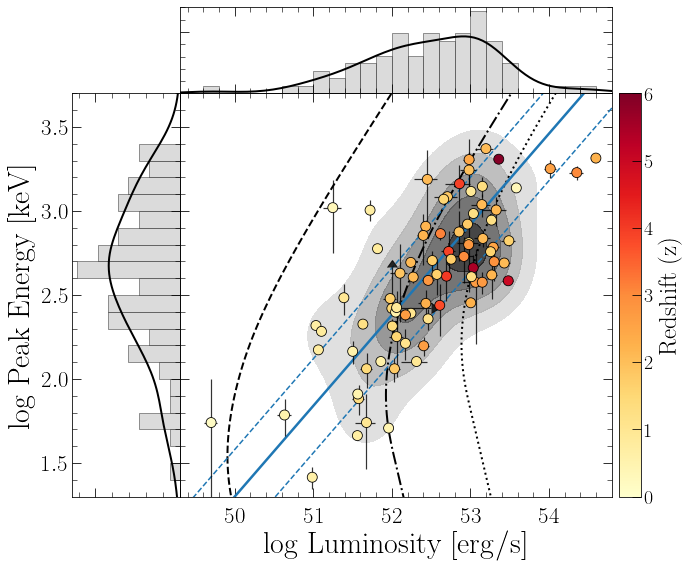

In [12]:
# This plot is to illustrate the Ep-L plane for the eBAT6 sample
plt.style.use('paper')
# plt.style.use('presentation')
def plot_eBAT6_EpL(fname=None, axes=None, fname_lim=None, mini_cax=False, kde=False):
    if fname is None:
        fname = root_dir/'catalogs/BAT6_cat/eBAT6_cat.txt'
    if fname_lim is None:
        fname_lim = root_dir/'resources/BAT6_detection_limit_EpL_plane.txt'

    if axes is None:
        fig, axes = pf.fig_marg(figsize=(10, 8), cb=True)
    else:
        fig = plt.gcf()

    if mini_cax:
        m_cax = fig.add_axes([0.780, 0.125, 0.015, 0.20])
        axes['mini_cb'] = m_cax
        fsize = 12
    else:
        axes['mini_cb'] = axes['cb']
        fsize = 25

    # Retrieve observational data
    Ep_obs = io.read_data(fname, 13, stripper='|', splitter='|', single_err=True)
    L_obs = io.read_data(fname, 15, stripper='|', splitter='|', single_err=True)
    z_obs = io.read_data(fname, 1, stripper='|', splitter='|', err=False)
    L_obs[0:3] = L_obs[0:3] * 10**51
    Ep_obs = msc.lin_to_log_ndarray(Ep_obs)
    L_obs = msc.lin_to_log_ndarray(L_obs)

    # Plot them
    art = pf.scatter_incomplete_ndarray(axes['center'], L_obs, Ep_obs, colormap=[z_obs[0],0.,6.,'YlOrRd'],
                                     marker='o', s=100, edgecolor='k', linewidth=0.8, label='eBAT6 observed data')
    mask = np.isfinite(L_obs[0]) & np.isfinite(Ep_obs[0])
    Ep_obs_masked = msc.mask_ndarray(Ep_obs, mask)
    L_obs_masked = msc.mask_ndarray(L_obs, mask)
    if kde:
        sns.kdeplot(L_obs_masked[0], Ep_obs_masked[0], ax=axes['center'], n_levels=5,
                    shade=True, shade_lowest=False, cmap='Greys', alpha=0.8)
    cb2 = fig.colorbar(art, cax=axes['mini_cb'])
    cb2.set_label('Redshift (z)', **{'size':fsize})
    cb2.ax.tick_params(labelsize=20)
    cb2.ax.tick_params(which='minor', right=False)

    # Detection limit of BAT6
    Ep_lim = io.read_column(fname_lim, 0, splitter='\t')
    z_lim = np.asarray([0.3, 2., 5.])
    L_lim = np.zeros((len(z_lim), len(Ep_lim)))
    ls = ['--', '-.',':']
    for i in range(len(z_lim)):
        L_lim[i] = io.read_column(fname_lim, i+1, splitter='\t')
        axes['center'].plot(np.log10(L_lim[i]), np.log10(Ep_lim), ls=ls[i], c='k', lw=2)

    # Relation of Pescalli+16
    logL_Pesc = np.linspace(49, 55)
    logEp_Pesc = -25.7 + 0.54*logL_Pesc
    sigma_Pesc = 0.28
    # Ep0 = 309. keV, alpha_amati = 0.54, sigma = 0.28
    art, = axes['center'].plot(logL_Pesc, logEp_Pesc, lw=2.5, color='C0')
    color_Pesc = plt.getp(art,'color')
    axes['center'].plot(logL_Pesc, logEp_Pesc+sigma_Pesc, ls='--', lw=1.5, color=color_Pesc)
    axes['center'].plot(logL_Pesc, logEp_Pesc-sigma_Pesc, ls='--', lw=1.5, color=color_Pesc)

    # Left histogram
    bins_Ep = np.linspace(1,4,31)
    axes['left'].hist(Ep_obs_masked[0], bins=bins_Ep, orientation='horizontal', label='eBAT6 observed',
                      edgecolor='k', linewidth=0.5, density=True, color='lightgray', alpha=0.8)
    sns.kdeplot(Ep_obs_masked[0], ax=axes['left'], vertical=True, color='k', linewidth=2)
    axes['left'].invert_xaxis()
    axes['left'].autoscale(True, axis='x')
    # Top histogram
    bins_L = np.linspace(49,55,31)
    axes['top'].hist(L_obs_masked[0], bins=bins_L, label='eBAT6 observed',
                     edgecolor='k',linewidth=0.5, density=True, color='lightgray', alpha=0.8)
    sns.kdeplot(L_obs_masked[0], ax=axes['top'], label='KDE', color='k', linewidth=2)
    axes['top'].get_legend().remove()
    axes['top'].autoscale(True, axis='y')


    # Axes formatting
    axes['left'].set_ylabel(r'log Peak Energy $\rm{[keV]}$')
    axes['center'].set_xlabel(r'log Luminosity $\rm{[erg/s]}$')
    axes['center'].set_xlim(49.3,54.8)
    axes['center'].set_ylim(1.3, 3.7)
    axes['center'].tick_params(labelsize=23)
    axes['left'].tick_params(labelsize=23)


    return

plot_eBAT6_EpL(kde=True)
plt.gcf().savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL.pdf', 
                  bbox_inches='tight')

Sample size :1313
Sample size :82


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


Model : 180430_S_A_nS0
Start, stop: [ 3000 32500 53000], [25000 50000 75000]
Model : 180430_S_A_nS0
Start, stop: [ 3000 32500 53000], [25000 50000 75000]
Model : 180430_S_A_nS0
Start, stop: [ 3000 32500 53000], [25000 50000 75000]
Model : 180430_S_A_nS
Start, stop: [ 3000 50000 53000], [25000 50000 75000]
Model : 180430_S_A_nS
Start, stop: [ 3000 50000 53000], [25000 50000 75000]
Model : 180430_S_A_nS
Start, stop: [ 3000 50000 53000], [25000 50000 75000]


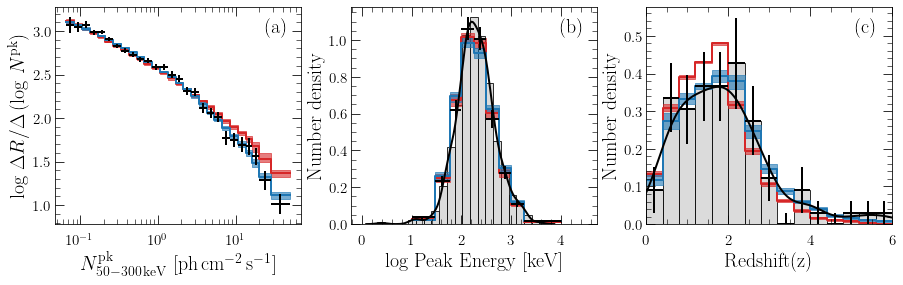

In [29]:
# This plot is to show an example of a bad fit to the observational constraints

plt.style.use('presentation')

fnames = {'k0_LN_nSFR':'180115_Sch_LogNorm_newSFR0',
          'kF_LN_nSFR':'180402_Schevol_LogNorm_newSFR0',
          'k0_LN_nF':'180509_S_LN_nS',
          'k05_LN_nF':'180416_Se_LN_nS',
          'k1_LN_nF':'180509_Se1_LN_nS',
          'k2_LN_nF':'180430_Se_LN_nS',
          'k0_A_nSFR':'180430_S_A_nS0',
          'kF_A_nSFR':'180402_Schevol_Amati_newSFR0',
          'k0_A_nF':'180430_S_A_nS',
         }
# This is the plot that shows all three observational constraints in one figure
bins_Ep = np.linspace(0,4.5, 30)

fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)

# Intensity Constraint
bins_Stern, obs_lin, err_lin = obs.create_Stern_hist()
x, x_errp, x_errm = pf.xerr_from_bins(bins_Stern, log=True)
axes[0].errorbar(x, obs_lin, xerr=[x_errm, x_errp], yerr=err_lin,  color='k', fmt='none')
axes[0].set_xscale('log')
axes[0].set_xlabel(r'$N^{\rm pk}_{50-300\,\rm keV}~\rm{[ph\,cm^{-2}\,s^{-1}]}$')
axes[0].set_ylabel(r'log $\Delta R/\Delta \,(\log\,N^{\rm pk})$')
axes[0].text(0.85, 0.88, '(a)', **{'size':20}, transform=axes[0].transAxes)

# Spectral Constraint
pf.plot_EpGBM(ax=axes[1], density=True, color='k', fmt='none', bins_log=True)
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_epeak',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'}],
                  log=True, verbose=True, kde=True,
                  bins=bins_Ep,
                  ax=axes[1], density=True, label='Spectral Constraint', alpha=0.8,
                  color='lightgray', errors='coerce', zorder=0)
axes[1].get_legend().remove()
axes[1].set_xlabel(r'log Peak Energy $\rm{[keV]}$')
axes[1].set_ylabel(r'Number density')
axes[1].text(0.85, 0.88, '(b)', **{'size':20}, transform=axes[1].transAxes)

# Redshift constraint
bins_eBAT6, obs_lin, err_lin = obs.create_eBAT6_hist(density=True)
z, z_errp, z_errm = pf.xerr_from_bins(bins_eBAT6)
df = pf.plot_obs_property('../catalogs/BAT6_cat/eBAT6_cat.txt', header=3,
                  key='redshift',
                  log=False, verbose=True, kde=True,
                  bins=bins_eBAT6,
                  ax=axes[2], density=True, label=None, alpha=0.8,
                  color='lightgray', errors='coerce', zorder=0)
axes[2].errorbar(z, obs_lin, xerr=[z_errm, z_errp], yerr=err_lin,  color='k', fmt='none')
axes[2].get_legend().remove()
axes[2].set_ylim(0)
axes[2].set_xlim(0,6)
axes[2].set_xlabel('Redshift(z)')
axes[2].set_ylabel(r'Number density')
axes[2].text(0.85, 0.88, '(c)', **{'size':20}, transform=axes[2].transAxes)




def extract_constraint(array_from_binary, constraint_index, model_index):
    """
        Extracts a property distribution from a binary-extracted array.
        Binary file is an output of the fortran MC GRB population code.

        Parameters:
        -----------

        constraint_index [int]
            The index where to find the property:
                Kommers       : 18
                Preece        : 19
                Stern         : 20
                EpGBM         : 21
                eBAT6         : 22
            Note : add 2 to each of these since the addition of tau, the temperature in the annealing version of the MCMC


        model_index [int]
            The index of the model you want to extract.

        len_constraint_array [int]
            The length of the property array to extract:
                Kommers       : 25
                Preece        : 10
                Stern         : 27
                EpGBM         : 9
                eBAT6         : 15

    """

    constraint_distr = array_from_binary[model_index][constraint_index]

    return constraint_distr


def post_process_constraint(array_from_binary, constraint_index, start, stop, len_constraint_array, one_plot_mode=False):
    """
        Post processes the output from the MC GRB population code for a given constraint.
        Start and stop are the indexes at which the chain is considered valid.
        Returns the median value for each bin and the + and - 1 sigma  errors.

    """
    if one_plot_mode:
        # stop and start are lists in this mode
        for j in range(len(stop)):
            if stop[j] > len(array_from_binary):
                stop[j] = len(array_from_binary)

            constraint_j = np.zeros((stop[j]-start[j],len_constraint_array))

            for i in range(start[j],stop[j]):
                constraint_j[i-start[j],:] = extract_constraint(array_from_binary, constraint_index, i)

            if j == 0:
                constraint = constraint_j
            else:
                constraint = np.concatenate((constraint, constraint_j))
    else:
        if stop > len(array_from_binary):
            stop = len(array_from_binary)

        constraint = np.zeros((stop-start,len_constraint_array))

        for i in range(start,stop):
            constraint[i-start,:] = extract_constraint(array_from_binary, constraint_index, i)

    constraint_final = np.median(constraint, axis=0)
    constraint_final_errp = np.zeros(len_constraint_array)
    constraint_final_errm = np.zeros(len_constraint_array)

    constraint_transposed = np.transpose(constraint)
    for i in range(len(constraint_transposed)):
        q = mstats.mquantiles(constraint_transposed[i], prob=[0.16, 0.5, 0.84])
        constraint_final_errp[i] = q[2] - q[1]
        constraint_final_errm[i] = q[1] - q[0]

    return constraint_final, constraint_final_errp, constraint_final_errm

base_dir = Path('/Volumes/LACIE SHARE/palmerio/Model_outputs')

# model = '180115_Sch_LogNorm_newSFR0'
# model2 = '180115_Sch_LogNorm_newSFR0'

def plot_constraint_from_MCMC(model, constraint, ax, version=1, color=None):
    if constraint not in ['Stern', 'EpGBM', 'eBAT6']:
        raise ValueError("constraint must be one of {}".format(['Stern', 'EpGBM', 'eBAT6']))
    
    starts = io.read_column(base_dir/model/'chain_index.txt', 0, splitter=',', dtype=int)
    stops  = io.read_column(base_dir/model/'chain_index.txt', 1, splitter=',', dtype=int)
    print('Model : {}'.format(model))
    print('Start, stop: {}, {}'.format(starts, stops))
    
    fname = base_dir/model/'reprise_MCMC.dat'
    if constraint == 'Stern':
        index = 22
        len_constraint = 27
    elif constraint == 'EpGBM':
        index = 23
        len_constraint = 9
    elif constraint == 'eBAT6':
        index = 24
        len_constraint = 15

    if version == 1:
        dt = np.dtype("i4, 24i4, 10f8, 10f8, 6f8, 6f8, 7f8, 7f8, 5f8, i4, f8, i4, 10f8, 10f8, 6f8, 500f8, 400f8, 200f8, 200f8, 360f8, 25f8, 10f8, 27f8, 9f8, 15f8, i4")
    elif version == 2:
        dt = np.dtype("i4, 24i4, 10f8, 10f8, 6f8, 6f8, 7f8, 7f8, 5f8, 2i4, f8, 10f8, 10f8, 6f8, 550f8, 440f8, 220f8, 220f8, 400f8, 25f8, 10f8, 27f8, 9f8, 15f8, i4")
        index -= 1

    # read the data
    with open(fname, 'rb') as f:
        sim_output_data = np.fromfile(f, dtype=dt, count=-1)

    # Extract the data you want
    y_mod, y_mod_errp, y_mod_errm = post_process_constraint(sim_output_data, 
                                                            index, starts, stops, 
                                                            len_constraint,
                                                            one_plot_mode=True)
    if constraint == 'Stern':
        bins, obs_lin, err_lin = obs.create_Stern_hist()
        # Convert to log
        y_mod, y_mod_errp, y_mod_errm = msc.lin_to_log(y_mod, y_mod_errp, y_mod_errm)
    elif (constraint == 'EpGBM') or (constraint == 'eBAT6'):
        # Turn histogram into density
        if constraint == 'EpGBM':
            bins, obs_lin, err_lin = obs.create_EpGBM_hist(bins_log=True)
        elif constraint == 'eBAT6':
            bins, obs_lin, err_lin = obs.create_eBAT6_hist()
        N_tot = np.sum(y_mod)
        delta_bin = bins[1:]-bins[:-1] 
        y_mod = y_mod/(N_tot*delta_bin)
        y_mod_errp = y_mod_errp/(N_tot*delta_bin)
        y_mod_errm = y_mod_errm/(N_tot*delta_bin)
        

    # Make it look better for plots
    x_plottable, y_mod_plottable = pf.plottable_hist(bins[:-1], y_mod, last_bin_edge=bins[-1])
    y_mod_errm_plottable = pf.double_array(y_mod_errm)
    y_mod_errp_plottable = pf.double_array(y_mod_errp)

    # Plot them
    art, = ax.plot(x_plottable, y_mod_plottable, label='Model', color=color, zorder=1)
    ax.fill_between(x_plottable,
                    y_mod_plottable+y_mod_errp_plottable,
                    y_mod_plottable-y_mod_errm_plottable,
                    alpha=0.6, color=plt.getp(art,'color'), zorder=plt.getp(art,'zorder'))
    return


plot_constraint_from_MCMC(fnames['k0_A_nSFR'], constraint='Stern', ax=axes[0], color='C3')
plot_constraint_from_MCMC(fnames['k0_A_nSFR'], constraint='EpGBM', ax=axes[1], color='C3')
plot_constraint_from_MCMC(fnames['k0_A_nSFR'], constraint='eBAT6', ax=axes[2], color='C3')
plot_constraint_from_MCMC(fnames['k0_A_nF'], constraint='Stern', ax=axes[0], color='C0')
plot_constraint_from_MCMC(fnames['k0_A_nF'], constraint='EpGBM', ax=axes[1], color='C0')
plot_constraint_from_MCMC(fnames['k0_A_nF'], constraint='eBAT6', ax=axes[2], color='C0')
# fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_k0_A_nSFR_and_k0_A_nF.pdf', 
#                   bbox_inches='tight')
plt.show()


Loading k0_LN_nF... Done
Loading k2_LN_nF... Done
Loading k0_A_nF... Done
Loading k2_A_nF... Done
################# k0_LN_nF #####################
D-stat, p_value = 0.077, 0.523
################# k2_LN_nF #####################
D-stat, p_value = 0.058, 0.853
################# k0_A_nF #####################
D-stat, p_value = 0.057, 0.865
################# k2_A_nF #####################
D-stat, p_value = 0.049, 0.950
[INFO] in compute_CDF_bounds_by_MC: initializing...
[INFO] in compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
[INFO] in compute_CDF_bounds_by_MC: starting bootstraps...
[INFO] in compute_CDF_bounds_by_MC: computing CDF...
[INFO] in compute_CDF_bounds_by_MC: plotting...


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


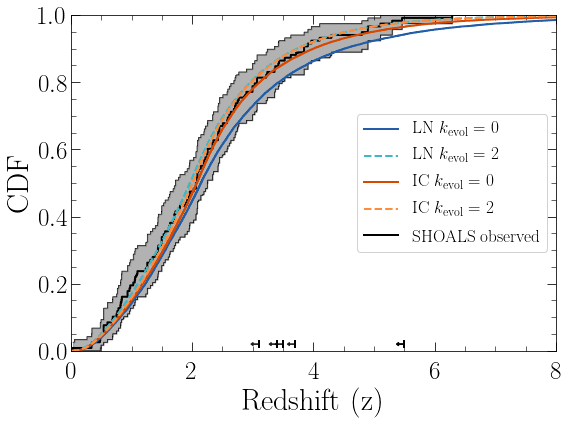

In [7]:
plt.style.use('paper')
model_names_ks = ['k0_LN_nF', 'k2_LN_nF', 'k0_A_nF', 'k2_A_nF']
best_pop_dir = '/Users/palmerio/Science_projects/GRB_population_model/model_outputs_non-dockerized/best_populations'
dfs = {}
for mod in model_names_ks:
    print(f'Loading {mod}... ', end='')
    dfs[mod] = pd.read_parquet(best_pop_dir + f'/population_{mod}')
    print('Done')

# Plot the redshift distribution expected for SHOALS in the case of k=0 and k=2 for LogNormal and Amati models
# Also compute the KS tests between these redshift distributions and the observed SHOALS redshift distribution
fig, ax = plt.subplots(figsize=(8,6))
df_obs = io.read_SHOALS_file()
for i,mod in enumerate(model_names_ks):
    if 'k2' in mod:
        ls = '--'
    else:
        ls = None
    if 'LN' in mod:
        scen = 'LN'
    else:
        scen = 'IC'
    label = f'{scen}'+r' $k_{\rm evol}=$'+f' {mod[1]}'

    print(f"################# {mod} #####################")
    pf.plot_SHOALS_distr(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['z'],
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color=colors[i],
                          mod_label=label, linestyle=ls, linewidth=2)
    D_stat, p_value = ks_2samp(dfs[mod][dfs[mod]['pdet_SHOALS']==1]['z'], df_obs['z'])
    print("D-stat, p_value = {:.3f}, {:.3f}".format(D_stat, p_value))

fname = root_dir/'catalogs/SHOALS_cat/SHOALS_cat.txt'
z_SHOALS =  io.read_data(fname,2, err=False)
mask = np.isfinite(z_SHOALS[0])
z_SHOALS = msc.mask_ndarray(z_SHOALS, mask)
pf.plot_ndarray_cdf_lim_only(ax, z_SHOALS, arrow_size=0.015)
st.compute_CDF_bounds_by_MC(sample=z_SHOALS[0],
                            sample_errp=z_SHOALS[1],
                            sample_errm=z_SHOALS[2],
                            sample_ll=z_SHOALS[4],
                            sample_ul=z_SHOALS[3],
                            ul_min_val=np.zeros(len(z_SHOALS[3])),
                            confidence=95.0,
                            positive=True,
                            precision=1000,
                            N_MC=10000,
                            bootstrap=True,
                            verbose=True,
                            show_plot=True,
                            ax=ax,
                            color='k',
                            show_median=True, zorder=0, label='SHOALS observed', linewidth=2)
ax.set_xlabel('Redshift (z)')
ax.set_xlim(0,8)
ax.set_ylim(0,1)
ax.legend()
fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr.pdf')


plt.show()

/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:115: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:116: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:117: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:115: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:116: 

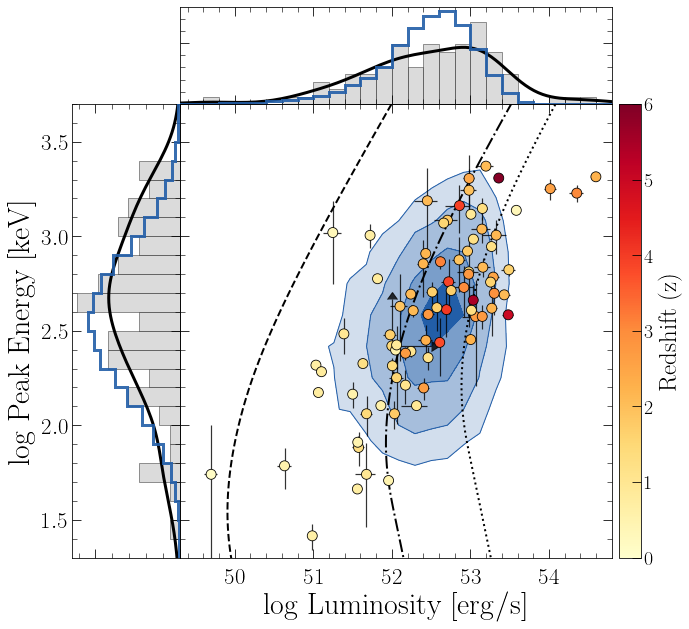

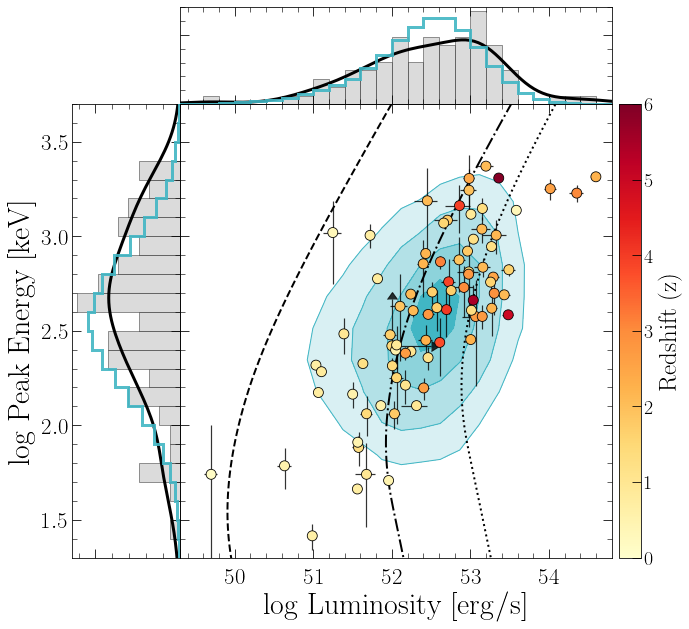

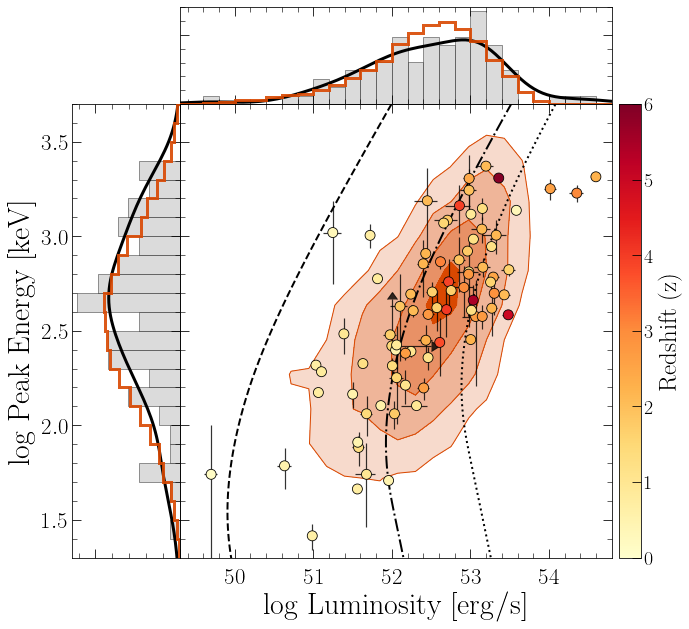

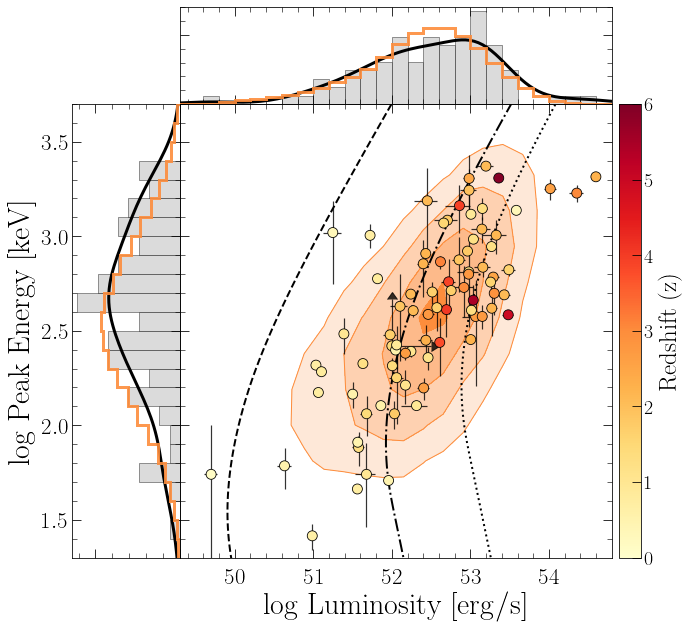

In [32]:
# plt.style.use('dark_background')
plt.style.use('paper')
for i,mod in enumerate(model_names_ks):
    cond = dfs[mod]['pht_pflx_BAT'] >= 2.6
    fig, axes = pf.cool_hist2d(np.log10(dfs[mod][cond]['L'].to_numpy()), np.log10(dfs[mod][cond]['Ep'].to_numpy()),
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                   left_hist_kwargs={'label': None,
                                     'bins':np.linspace(1,4,31),
                                     'edgecolor':colors[i],
                                     'linewidth':3,
                                     'zorder':5,
                                     'alpha':0.9,
                                     'histtype':'step'},
                   top_hist_kwargs={'label': None,
                                    'bins': np.linspace(49,55,31),
                                    'edgecolor': colors[i],
                                    'linewidth':3,
                                    'zorder':5,
                                    'alpha':0.9,
                                    'histtype':'step'},
                   hist2d_kwargs={'color':colors[i], 
                                  'contour_kwargs':{'linewidths':1},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':True})
    plot_eBAT6_EpL(axes=axes, mini_cax=False)
#     fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/EpL_{}.pdf'.format(mod),
#                 bbox_inches='tight')

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


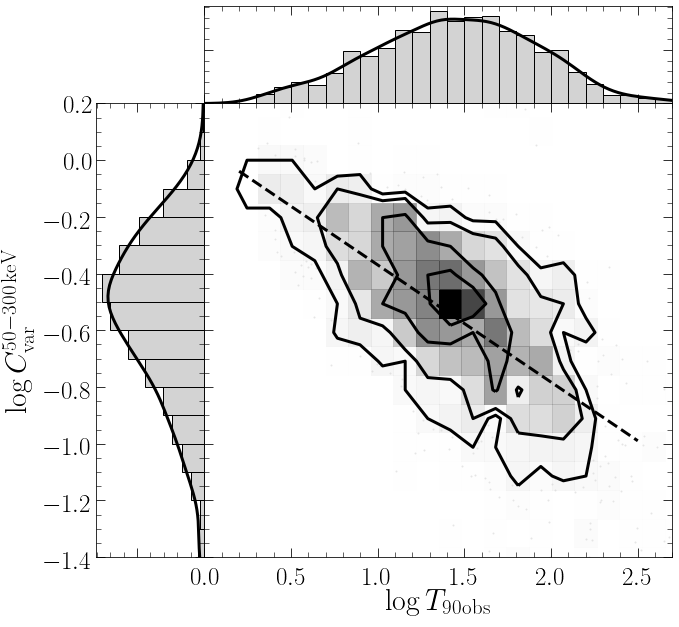

In [18]:
# Cvar plot
def calculate_Cvar(fname, pflx_key='pflx_band_phtfluxb',
                          flnc_key='flnc_band_phtflncb',
                          t90_key='t90',
                          lac=False,
                          pflx_min=None,
                          verbose=False, add_fluences=False):
    """
        Read the fname provided with pandas and extract T90, fluence and peak flux.
        The mean flux is then calculated as fluence/T90.
        Cvar is then calculated as mean flux/peakflux.
        lac means long and complete; if True the sample will be cut at the desired minimum pflx
    """
    # Read the entire file
    df_obs = pd.read_csv(fname, sep='|', header=2, low_memory=False)
    # Strip the colum names to remove whitespaces
    df_obs.rename(columns=lambda x:x.strip(), inplace=True)
    # Activate verbose to check the column names
    if verbose:
        for i,col in enumerate(df_obs.columns):
            print(i,col)
    if add_fluences:
        flnc_2 = 'fluence_2'
        flnc_3 = 'fluence_3'
        flnc_key = 'flnc_tot'
        df_obs[flnc_2] = pd.to_numeric(df_obs[flnc_2], errors='coerce')
        df_obs[flnc_3] = pd.to_numeric(df_obs[flnc_3], errors='coerce')
        df_obs[flnc_key] = df_obs[flnc_2] + df_obs[flnc_3]

    # Only keep necessary data in new sub-dataframe
    necessary_data = {'pflx':df_obs[pflx_key], 'flnc':df_obs[flnc_key], 't90':df_obs[t90_key]}
    df_sub = pd.DataFrame(data=necessary_data)
    
    # Convert the values read from strings to numbers
    if verbose:
        print("Before conversion to numeric:\n", df_sub)
    for key in ['pflx', 'flnc', 't90']:
        df_sub[key] = pd.to_numeric(df_sub[key], errors='coerce')
    
    # Remove NaN values
    if verbose:
        print("Before removing NaNs:\n", df_sub)
    df_sub = df_sub.dropna(axis=0)

    # Calculate mean flux and Cvar
    df_sub['mflx'] = df_sub['flnc'] / df_sub['t90']
    df_sub['Cvar'] = df_sub['mflx'] / df_sub['pflx']
    # Only keep the long and complete part of the sample
    if lac:
        df_sub = df_sub[(df_sub['t90'] > 2) & (df_sub['pflx'] > pflx_min)]
    return df_sub

def fit_Cvar_T90_slope(df, show_plot=True):
    """
        Fit the slope of the Cvar vs T90 relation by minimizing the scatter of the decorrelated Cvar sample
    """
    
    from scipy.stats import linregress
    best_slope, best_intercept, r_value, p_value, std_err = linregress(np.log10(df['t90']),
                                                                       np.log10(df['Cvar']))
    
    mu, std = norm.fit(np.log10(df['Cvar'])-best_slope*np.log10(df['t90']) - best_intercept)
    mu_t90, std_t90 = norm.fit(np.log10(df['t90']))

    if show_plot:

        fig, axes = pf.cool_hist2d(np.log10(df['t90']),
                    np.log10(df['Cvar'])-best_slope*np.log10(df['t90'])-best_intercept,
                    c=np.log10(df['pflx']),
                    xlabel=r'$\rm \log(T_{90}~[s])$',
                    ylabel=r'$\rm \log(C_{var})$'+f'-{np.abs(best_slope):.3f}'+r'$\,\rm \log(T_{90}~[s])$'+f'+{best_intercept:.3f}',
                    cblabel=r'$\log(N~[\rm ph\,s^{-1}\,cm^{-2}])$',
                    top_hist_kwargs={'label': None,
                                     'bins': 20,
                                     'color': 'lightgrey',
                                     'edgecolor':'k'},
                    left_hist_kwargs={'label': None,
                                     'bins': 20,
                                     'color': 'lightgrey',
                                     'edgecolor':'k'},)

        x = np.linspace(-1,1,1000)
        x_t90 = np.linspace(0.3,3,1000)
        axes['left'].plot(pf.gaussian(x,mu,std,normed=True),x, label=r'$\mu = ${:.2f}~$\sigma =${:.2f}'.format(mu, std))
        axes['top'].plot(x_t90,pf.gaussian(x_t90,mu_t90,std_t90,normed=True), label=r'$\mu = ${:.2f}~$\sigma =${:.2f}'.format(mu_t90, std_t90))

        axes['left'].legend()
        axes['top'].legend()
    fit_results = {'best_slope':best_slope,
                   'best_intercept':best_intercept,
                   'mu_decorr':mu,
                   'sigma_decorr':std,
                   'mu_t90':mu_t90,
                   'sigma_t90':std_t90}
    return fit_results

pflx_min = 0.9
# Compute Cvar
filename = Path('../catalogs/GBM_cat/fermi_GBM_cat_total.dat')
df = calculate_Cvar(filename,
                    pflx_key='pflx_band_phtfluxb',
                    flnc_key='flnc_band_phtflncb',
                    lac=True, pflx_min=pflx_min)
# Cut out bad part of sample
T90_condition = (df['t90'] >= 2)
Pflx_condition = (df['pflx'] >= pflx_min)
outliers_condition = (df['t90'] <= 10**0.6) & (df['Cvar'] <= 10**-0.5)
final_mask = T90_condition & Pflx_condition & ~outliers_condition
df_lac = df[final_mask].copy()
df_lac.dropna(inplace=True)
df_lac['log_t90'] = np.log10(df_lac['t90'])
df_lac['log_Cvar'] = np.log10(df_lac['Cvar'])

fig, axes = pf.cool_hist2d(df_lac['log_t90'].to_numpy(),
                           df_lac['log_Cvar'].to_numpy(),
                           cb=False,
                           mode='hist2d',
                           figsize=(10,9),
                           plot_left_kdeplot=True,
                           plot_top_kdeplot=True,
                           left_hist_kwargs={'label': None,
                                             'bins':np.linspace(-1.5,0.5,21),
                                             'color':'lightgrey'},
                           top_hist_kwargs={'label': None,
                                            'bins': np.linspace(0,3,31),
                                            'color':'lightgrey'},
                           kde2d_kwargs={'n_levels':5,
                                         'shade':True,
                                         'shade_lowest':False,
                                         'cmap':'Greys',
                                         'alpha':0.8,
                                         'legend':False,
                                         'zorder':0})
axes['top'].get_legend().remove()
axes['center'].set_xlabel(r'$\log T_{90 \rm obs}$')
axes['left'].set_ylabel(r'$\log C^{50-300\,\rm keV}_{\rm var}$')
axes['left'].get_legend().remove()
axes['center'].set_xlim(0,2.7)
axes['center'].set_ylim(-1.4,0.2)

results = fit_Cvar_T90_slope(df_lac, show_plot=False)
logt90 = np.linspace(0.2, 2.5, 50)
logCvar = results['best_slope']*logt90 + results['best_intercept']
axes['center'].plot(logt90, logCvar, ls='--', color='k')
# df_lac['log_Cvar_decorr'] = df_lac['log_Cvar'] + results['best_slope']*df_lac['log_t90']
# fig, axes = pf.cool_hist2d(df_lac['log_t90'].to_numpy(),
#                            df_lac['log_Cvar_decorr'].to_numpy(),
#                            cb=False,
#                            mode='kde2d',
#                            figsize=(10,9),
#                            plot_left_kdeplot=True,
#                            plot_top_kdeplot=True,
#                            left_hist_kwargs={'label': None,
#                                              'bins':np.linspace(-1.5,1.5,31),
#                                              'color':'lightgrey'},
#                            top_hist_kwargs={'label': None,
#                                             'bins': np.linspace(0,3,31),
#                                             'color':'lightgrey'},
#                            kde2d_kwargs={'n_levels':5,
#                                          'shade':True,
#                                          'shade_lowest':False,
#                                          'cmap':'Greys',
#                                          'alpha':0.8,
#                                          'legend':False,
#                                          'zorder':0})
# # sns.kdeplot(df_lac['log_t90'], df_lac['log_Cvar_decorr'],
# #             n_levels=5,shade_lowest=False,
# #             cmap='Greys',
# #             alpha=0.8,
# #             legend=False, ax=axes['center'])
# axes['left'].get_legend().remove()
# axes['top'].get_legend().remove()
# axes['center'].set_xlabel(r'$\rm \log~T_{90}$')
# axes['left'].set_ylabel(r'$\rm \log(C^{50-300\,\rm keV}_{var})\,+$'+'{:.3f}'.format(results['best_slope'])+r'$\,\rm \log(T_{90}~[s])$')
# axes['center'].set_xlim(0,3)
# axes['center'].set_ylim(-1.5,1.5)
fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/Cvar_vs_T90.pdf',
                bbox_inches='tight')
plt.show()

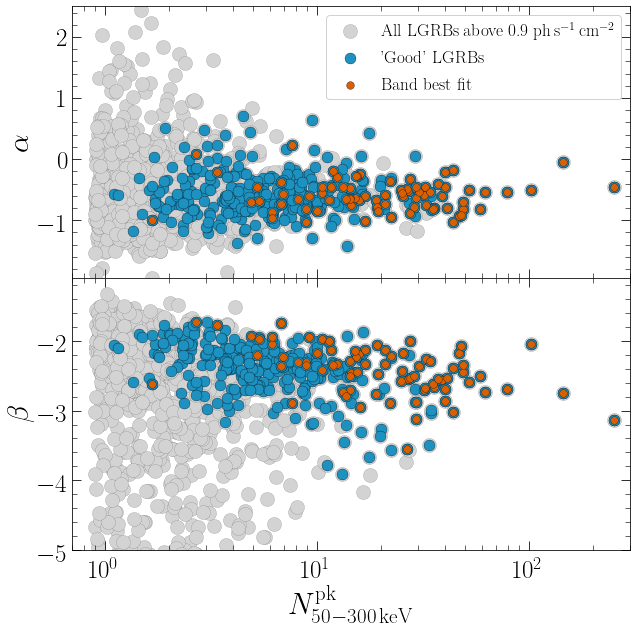

In [27]:
# Plot to show Band is best model at high peak flux

# Calculate the 'good' sample defined in Gruber+14
func_list = [msc.calc_rel_errors_GBM_band]
func_list += [msc.filter_df for i in range(7)]
df_good = msc.create_filtered_sample('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  keys=['pflx_band_phtfluxb','pflx_band_alpha','pflx_band_beta'],
                  func=func_list,
                  func_args=[{},
                             {'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_alpha_pos_err', 'lim_max':0.4, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_beta_pos_err', 'lim_max':1.0, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_beta_pos_err', 'lim_max':1.0, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_epeak_rel_err', 'lim_max':0.4, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_ampl_rel_err', 'lim_max':0.4, 'errors':'coerce'}],
                                     errors='coerce')
# Calculate the long and complete sample with pflx > 0.9 ph/s/cm2 and t90 > 2 s
df_lac = msc.create_filtered_sample('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  keys=['pflx_band_phtfluxb','pflx_band_alpha','pflx_band_beta'],
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'}],
                                    errors='coerce')

# Calculate the 'Band best' sample where Band is the best fit
df_band = msc.create_filtered_sample('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  keys=['pflx_band_phtfluxb','pflx_band_alpha','pflx_band_beta'],
                  func=[msc.filter_df for i in range(3)],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'},
                             {'filtering_key':'pflx_best_fitting_model', 'equal':'pflx_band', 'string':True}],
                                     errors='coerce')



fig, axes = plt.subplots(2,1, sharex=True, tight_layout=False, figsize=(10,10))

axes[0].scatter(df_lac['pflx_band_phtfluxb'],
                df_lac['pflx_band_alpha'], color='lightgrey', s=200, edgecolor='k', linewidth=0.1,
                label=r'All LGRBs above 0.9 $\rm ph\,s^{-1}\,cm^{-2}$')
axes[1].scatter(df_lac['pflx_band_phtfluxb'],
                df_lac['pflx_band_beta'], color='lightgrey', s=200, edgecolor='k', linewidth=0.1)
axes[0].scatter(df_good['pflx_band_phtfluxb'],
                df_good['pflx_band_alpha'], color='#1d91c0', s=120, edgecolor='k', linewidth=0.3,
                label="'Good' LGRBs")
axes[1].scatter(df_good['pflx_band_phtfluxb'],
                df_good['pflx_band_beta'], color='#1d91c0', s=120, edgecolor='k', linewidth=0.3)
axes[0].scatter(df_band['pflx_band_phtfluxb'],
                df_band['pflx_band_alpha'], color='#1d91c0', s=120, edgecolor='k', linewidth=0.3)
axes[1].scatter(df_band['pflx_band_phtfluxb'],
                df_band['pflx_band_beta'], color='#1d91c0', s=120, edgecolor='k', linewidth=0.3)
axes[0].scatter(df_band['pflx_band_phtfluxb'],
                df_band['pflx_band_alpha'], color='#d95f02', s=60, edgecolor='k', linewidth=0.3,
                label="Band best fit")
axes[1].scatter(df_band['pflx_band_phtfluxb'],
                df_band['pflx_band_beta'], color='#d95f02', s=60, edgecolor='k', linewidth=0.3)

fig.subplots_adjust(hspace=0)
axes[0].legend()
axes[1].set_xlabel(r'$N^{\rm pk}_{50-300\,\rm keV}$')
axes[1].set_ylabel(r'$\beta$')
axes[0].set_ylabel(r'$\alpha$')
axes[0].set_xscale('log')
axes[0].set_xscale('log')
axes[0].set_xlim(0.7,300)
axes[0].set_ylim(-1.95,2.5)
axes[1].set_ylim(-5,-1.1)
fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/Band_alpha_beta_vs_pflx.pdf',
            bbox_inches='tight')
plt.show()

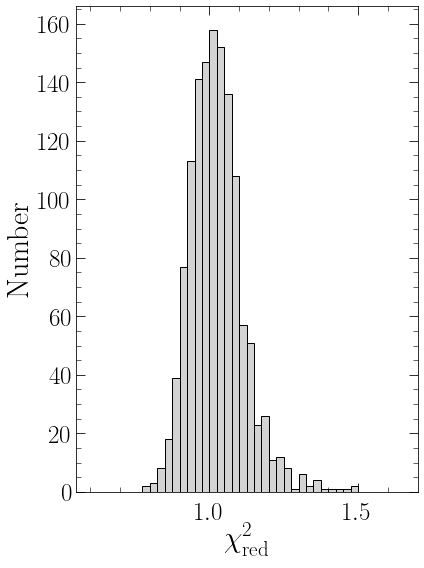

In [35]:
fig, ax = plt.subplots(figsize=(6,8))
df_lac = pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                              key='pflx_band_redchisq',
                              func=[msc.filter_df, msc.filter_df],
                              func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                                         {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'}],
                              errors='coerce', ax=ax,
                              bins=np.linspace(0.5,2,61),
                              color='lightgrey', density=False, kde=False)
ax.set_xlim(0.55,1.7)
ax.set_xlabel(r'$\chi^2_{\rm red}$')
ax.set_ylabel('Number')
# fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/Band_redchisq.pdf',
#             bbox_inches='tight')
plt.show()

14:58:08.691 [INFO] Subsampling done in 2.219 s
14:58:12.959 [INFO] KS calculations done in 4.268 s
14:58:15.903 [INFO] CDF calculation done in 2.944 s


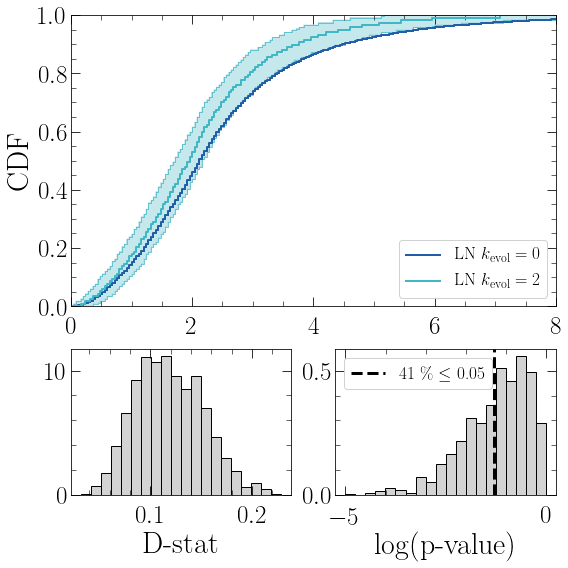

In [2]:
dfs = {}
model_names = ['k0_LN_nF','k2_LN_nF']
for mod in model_names:
    dfs[mod] = pd.read_parquet(f'../model_outputs_non-dockerized/best_populations/population_{mod}')

def subsample_and_KS(df1, df2, N_sub, key, confidence=95.0, N_bs=100, precision=500, bins=None,
    show_plot=False, label1=None, label2=None, subsample1=True, subsample2=True, color1=None, color2=None):
    """
        Compute the K-S test between a subsample of size N_sub.
        Repeat the K-S test for N_bs bootstraps and create a distribution of p-values.
    """

    t1 = time.time()
    if subsample1:
        subsamp1 = st.subsample_with_bootstrap(df1, key=key, N_sub=N_sub, N_bs=N_bs)
    else:
        subsamp1 = df1[key].to_numpy()[:,np.newaxis] * np.ones(N_bs)
        subsamp1 = subsamp1.T
    if subsample2:
        subsamp2 = st.subsample_with_bootstrap(df2, key=key, N_sub=N_sub, N_bs=N_bs)
    else:
        subsamp2 = df2[key].to_numpy()[:,np.newaxis] * np.ones(N_bs)
        subsamp2 = subsamp2.T
    t2 = time.time()
    log.info(f"Subsampling done in {t2-t1:.3f} s")

    t1 = time.time()
    D_stat, p_value = st.compute_KS_with_bootstrap(subsamp1, subsamp2, N_bs)
    t2 = time.time()
    log.info(f"KS calculations done in {t2-t1:.3f} s")

    t1 = time.time()
    CDF1 = st.CDF_with_bootstrap(subsamp1, bins=bins)
    CDF2 = st.CDF_with_bootstrap(subsamp2, bins=bins)
    med1, lw1, up1 = st.compute_CDF_quantiles(CDF1, confidence=confidence)
    med2, lw2, up2 = st.compute_CDF_quantiles(CDF2, confidence=confidence)
    t2 = time.time()
    log.info(f"CDF calculation done in {t2-t1:.3f} s")

    pfrac = len(p_value[np.where(p_value < (1.-confidence/100.))[0]])/len(p_value)

    if show_plot:
        pf.plot_CDFs_and_KS_results(bins=bins, med1=med1, med2=med2, lw1=lw1, lw2=lw2, up1=up1, up2=up2,
                                    D_stat=D_stat,
                                    p_value=p_value,
                                    confidence=confidence,
                                    pfrac=pfrac,
                                    label1=label1,
                                    label2=label2,
                                    color1=color1,
                                    color2=color2)

    return bins, med1, med2, lw1, lw2, up1, up2, D_stat, p_value, confidence, pfrac

N_bs = 1000
N_sub = 117
thrsh = 1e-6
precision=500
bins, med1, med2, lw1, lw2, up1, up2, D_stat, p_value, confidence, pfrac = subsample_and_KS(dfs[model_names[0]][(dfs[model_names[0]]['erg_flnc_BAT']>=thrsh)],
                 dfs[model_names[1]][(dfs[model_names[1]]['erg_flnc_BAT']>=thrsh)],
                 key='z',
                 precision=precision,
                 bins=np.linspace(0,20,precision+1),
                 N_sub=N_sub,
                 N_bs=N_bs,
                 show_plot=False, subsample1=False)

from matplotlib import gridspec
fig = plt.figure(figsize=(8,8),tight_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[1,1])
ax = fig.add_subplot(gs[0,:])
axD = fig.add_subplot(gs[1,0])
axp = fig.add_subplot(gs[1,1])

ax.set_ylabel('CDF')
axD.set_xlabel('D-stat')
axp.set_xlabel('log(p-value)')
axD.hist(D_stat, bins=20, color='lightgray', density=True)
if pfrac is None:
    pfrac = len(p_value[np.where(p_value < (1.-confidence/100.))[0]])/len(p_value)

plabel = "{:.0f} \% $\leq$ {:.2f}".format(100*pfrac, 1.-confidence/100.)
axp.hist(np.log10(p_value), bins=20, color='lightgray', density=True)
axp.axvline(np.log10(1.-confidence/100.), ls='--', color='k', label=plabel)
axp.legend()

bins_mid = 0.5*(bins[1:]+bins[:-1])
pf.plot_CDF_with_bounds(bins_mid, med1, lw1, up1, ax=ax, 
                        label=r'LN $k_{\rm evol}=0$',
                        lw=2,
                        color=colors[0])
pf.plot_CDF_with_bounds(bins_mid, med2, lw2, up2, ax=ax,
                        label=r'LN $k_{\rm evol}=2$',
                        lw=2,
                        color=colors[1])
ax.set_ylim(0,1)

ax.set_xlim(0,8)
ax.legend()
fig.savefig('/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/k0_k2_LN_SHOALS_discr.pdf.pdf',
            bbox_inches='tight')
plt.show()

LN


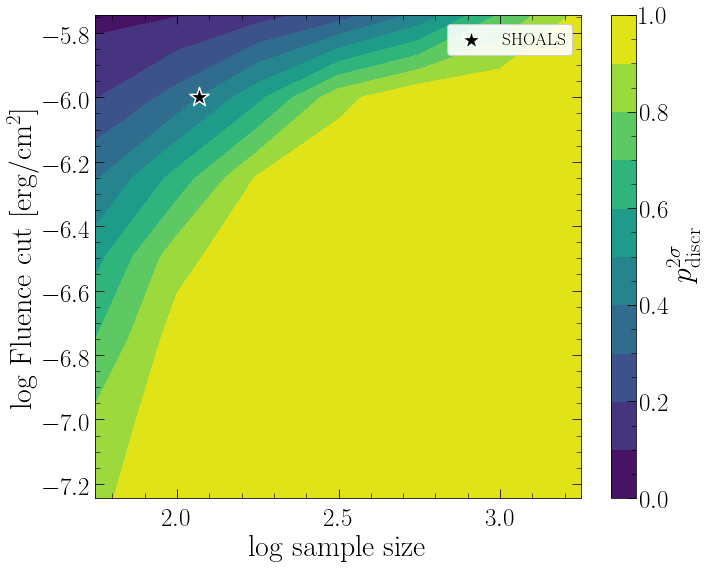

A


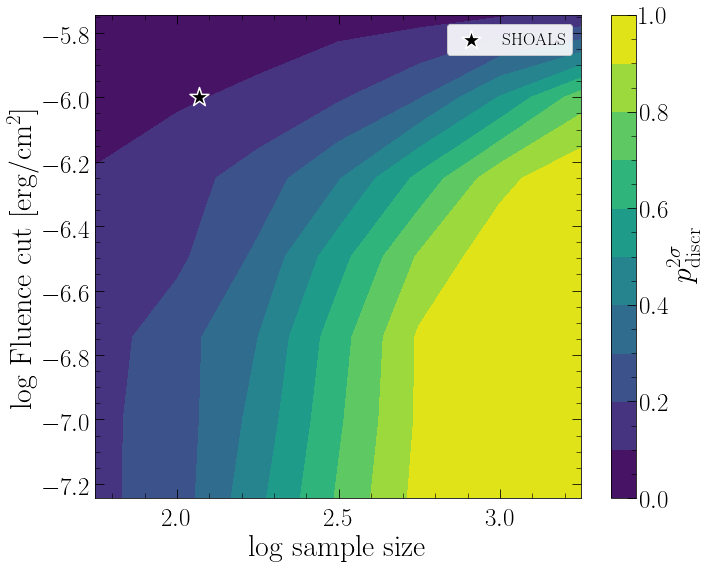

In [20]:
# Now we want to explore the fluence cut vs sample size plane and see what is required to discriminate
# between k=0 and k=2. We create two arrays for the fluence cuts and the sample size we reasonably expect
# can be obtained and compute the fraction of bootstrap samples that have a p-value below 0.05
# We associate this fraction with the probability of discriminating between the k=0 and k=2 scenarios at the
# 95% confidence level.
plt.style.use('paper')
flnc_cuts = np.array([1.8e-6, 1e-6, 5.6e-7, 3.2e-7, 1.8e-7, 1e-7, 5.7e-8])
size = np.array([56, 100, 178, 316, 562, 1000, 1780])
p_discr_z = {}
p_discr_L = {}
for mod in ['LN','A']:
    p_discr_z[mod] = pd.read_parquet(f'../model_outputs_non-dockerized/best_populations/p_discr_z_{mod}').to_numpy()


# Create the 2D plane 'fluence cut' vs 'sample size' and plot the probability of discriminating between
# k=0 and k=2 models at the 2 sigma confidence level for the LogNormal scenarios
def plot_fluence_cut_vs_sample_size(size, flnc_cuts, frac, show_indiv_pts=False):
    fig, ax = plt.subplots(figsize=(10,8))
    log_size_2D, log_flnc_cuts_2D = np.meshgrid(np.log10(size), np.log10(flnc_cuts))
    N_colors = 10
    # WARNGING : must use the transpose of frac here because of the way contourf expects the input
    art = ax.contourf(log_size_2D, log_flnc_cuts_2D, frac.T, levels=9)
    cb = fig.colorbar(art)
    if show_indiv_pts:
        for i, j in product(range(len(size)), range(len(flnc_cuts))):
            ax.scatter(np.log10(size[i]), np.log10(flnc_cuts[j]), s=10, marker='.', color='k')
            ax.text(np.log10(size[i]), np.log10(flnc_cuts[j]), "{:.2f}".format(frac[i,j]))
    cb.set_label(r"$p^{2\sigma}_{\rm discr}$")
    ax.set_xlabel("log sample size")
    ax.set_ylabel("log Fluence cut [erg/cm$^2$]")
    return

for key, value in p_discr_z.items():
    print(key)
    plot_fluence_cut_vs_sample_size(size, flnc_cuts, value)
    ax = plt.gca()
    ax.scatter(np.log10(117), -6, s=400, marker='*', linewidth=1.5, edgecolor='w', color='k', label='SHOALS')
    ax.legend(loc='best')
    plt.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/flnc_sampsize_{key}.pdf')
    plt.show()